# Time Series Modelling : Forecasting Exercises

09 February 2023


Using saas.csv

Bonus:

    Using the store item demand data, create a forecast of sales_total and quantity for 2018 using the Previous Cycle approach. .
    Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
    Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
    Plot the 2018 monthly sales predictions.



In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns
import plot_eval_functions as p

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
# importing the csv

saas = pd.read_csv('saas.csv')

In [3]:
saas.head(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0


In [4]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# renaming awkward cols

saas = saas.rename(columns = {'Month_Invoiced':'month_invoiced', 'Customer_Id':'customer_id',
                              'Amount': 'amount'})

In [6]:
# dropping unnecessary cols

saas = saas.drop(columns = {'Invoice_Id', 'Subscription_Type', 'customer_id'})

In [7]:
# change 'sale_date' to datetime format
saas['month_invoiced'] = pd.to_datetime(saas['month_invoiced'])
    
# setting 'sale_date' as index and sorting it
saas = saas.set_index('month_invoiced').sort_index()

In [8]:
saas.head(3)

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0


### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [9]:
# aggregating

saas_agg = saas.groupby('month_invoiced').sum()
saas_agg.head(3)

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0


In [10]:
# set train size to be 50% of total 

train_size = int(round(saas_agg.shape[0] * 0.5))

train_size

24

In [11]:
# set validate size to be 30% of total 

val_size = int(round(saas_agg.shape[0] * 0.3))

val_size

14

In [12]:
# set test size

test_size = int(round(saas_agg.shape[0] * 0.2))

In [13]:
# train : data to the end of 'train_size'

train = saas_agg[:train_size]

train.shape

(24, 1)

In [14]:
# validate to the end
val_end_index = train_size + val_size

val_end_index

38

In [15]:
# setting val

val = saas_agg[train_size:val_end_index]
val.shape

(14, 1)

In [16]:
# setting test

test = saas_agg[val_end_index:]

test.shape

(10, 1)

In [17]:
# verifying splits

print(saas_agg.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


###      Forecast, plot and evaluate using each at least 4 of the methods we discussed :
        Last-Observed Value
        Simple Average
        Moving Average
        Holt's Linear Trend
        Holt's Seasonal Trend
        Based on previous year/month/etc, this is up to you.


<AxesSubplot:xlabel='month_invoiced'>

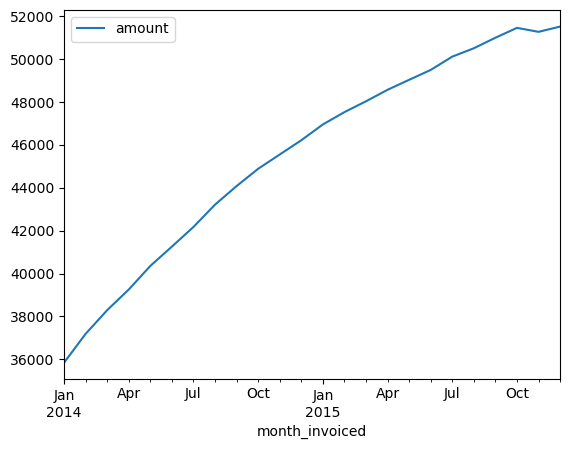

In [18]:
# plotting train

train.plot()

### Last-Observed Value

In [19]:
# take the last item of 'amount' and assign to variable

last_sales = train['amount'][-1:][0]

In [20]:
# create the yhat / baseline

yhat_df = pd.DataFrame({'amount': [last_sales]}, index = val.index)

# index uses the index of the validate dataset. Keeps the length the same

# the brackets allow dico to be filled to full length of index

yhat_df.head(3)

,amount
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0


In [21]:
# function to get the RMSE

# p.eval(val, yhat_df, 'amount')

The RMSE is 1343.0


In [28]:
# get the rmse

rmse = round(sqrt(mean_squared_error(val['amount'], yhat_df['amount'])), 0)
rmse

1343.0

The RMSE is 1343.0


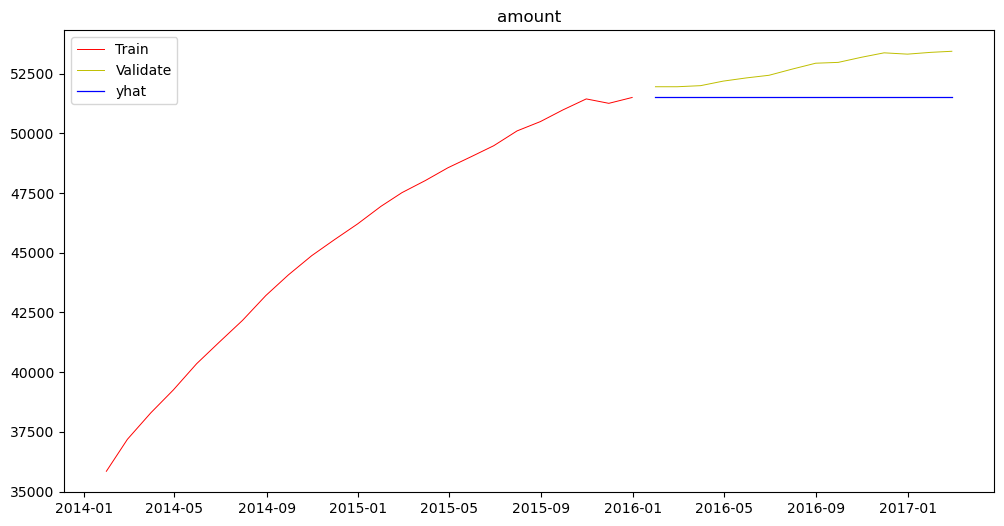

In [34]:
# p.plot_eval(train, val, yhat_df, 'amount')

plt.figure(figsize = (12, 6))
    
plt.plot(train['amount'], label = 'Train', linewidth = 0.7, color = 'r')
plt.plot(val['amount'], label = 'Validate', linewidth = 0.7, color = 'y')
plt.plot(yhat_df['amount'], label = 'yhat', linewidth = 0.9, c = 'b')
    
plt.legend()
plt.title('amount')
    
print(f'The RMSE is {rmse}')
    
plt.show()


In [35]:
# create an empty dataframe

eval_df = pd.DataFrame(columns = ['model_type', 'target', 'RMSE'])

eval_df

,model_type,target,RMSE


In [45]:
# adding 'last_observed_value' results to eval_df
    
d = {'model_type': ['last_observed_value'], 'target': ['amount'],
        'RMSE': [rmse]}
    
d = pd.DataFrame(d)
    
eval_df.append(d, ignore_index = True)

,model_type,target,RMSE
0,last_observed_value,amount,1343.0


### Simple Average

In [48]:
# compute simple average of 'amount' (from train data)

amt = round(train['amount'].mean(), 2)

print(f'The simple average is {amt}.')

The simple average is 45568.54.


In [80]:
def make_baseline_predictions(amount_predictions = None):
    
    yhat_df_simple = pd.DataFrame({'amount': [amount_predictions]},
                          index = val.index)
    
# here, yhat is the simple average baseline model

    return yhat_df

In [81]:
yhat_df_simple = make_baseline_predictions(amt)

In [82]:
# create the yhat / baseline for simple average

yhat_df_simple.head(3)

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54


The RMSE is 1343.0


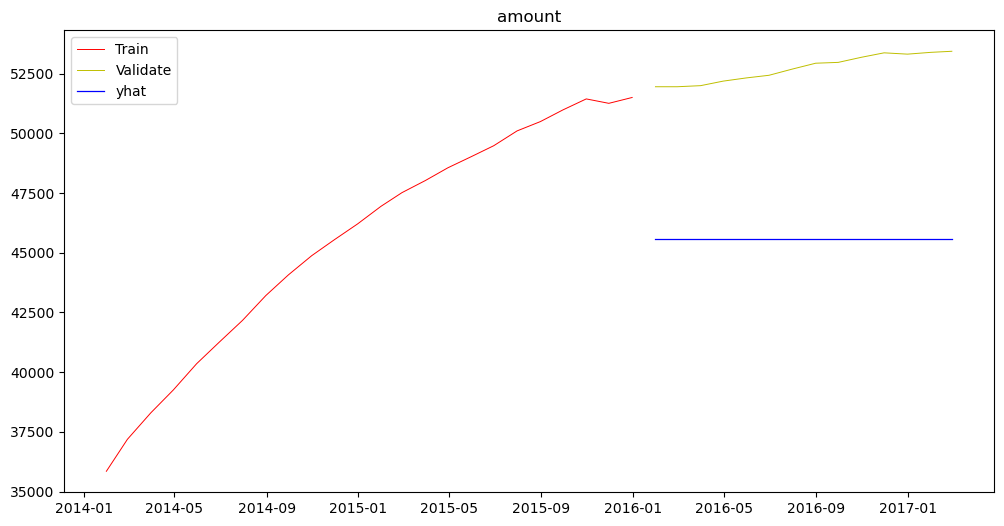

In [83]:
# plotting the simple average

plt.figure(figsize = (12, 6))
    
plt.plot(train['amount'], label = 'Train', linewidth = 0.7, color = 'r')
plt.plot(val['amount'], label = 'Validate', linewidth = 0.7, color = 'y')
plt.plot(yhat_df_simple['amount'], label = 'yhat', linewidth = 0.9, c = 'b')
    
plt.legend()
plt.title('amount')
    
print(f'The RMSE is {rmse}')
    
plt.show()